In [1]:
#supress warnings (especially from sklearn)
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import LeaveOneOut
from sklearn.linear_model import ElasticNetCV, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, average_precision_score, precision_recall_curve, roc_curve, auc
from sklearn.decomposition import PCA
import seaborn as sns
import csv

<h2> Preprocessing </h2>

patient_ccs_100.csv contains the clusters (k=3) of patients after running k-modes. First, we merge the cluster information in with all the feature data. Then, we merge the readmission labels with the data to preserve the true labels. Then, we drop the CCS_codes field and the ICD9_codes fields because they are irrelevant past the clustering analysis. We then save this data to a csv file. We also drop the subject_id and hadm_id because they are also not relevant in developing models for the data. We then save this version of the data as well. 

In [2]:
ccs_data = pd.read_csv('../data/patient_ccs_100.csv')
ccs_data = ccs_data.rename(index=str, columns={"SUBJECT_ID": "subject_id", "HADM_ID": "hadm_id"})
all_data = pd.read_csv('../data/x_with_lacefeatures.csv')
labels = pd.read_csv('../data/y_more_no_df_clean.csv')
merged_data = all_data.merge(ccs_data, on=['subject_id', 'hadm_id'])
labeled_data = merged_data.join(labels)
labeled_data = labeled_data.drop(['CCS_codes', 'ICD9_CODES'], axis=1)
labeled_data.to_csv('../data/labeled_clustered_data_with_ids.csv')
save_labeled_data = labeled_data.drop(['subject_id', 'hadm_id'], axis=1)
save_labeled_data.to_csv('../data/labeled_clustered_data.csv')

<h3>Readmissions by Cluster</h3>

Each cluster is grouped by the number of patients that were readmitted and belong to that particular cluster. These values are then visualized in a bar graph.

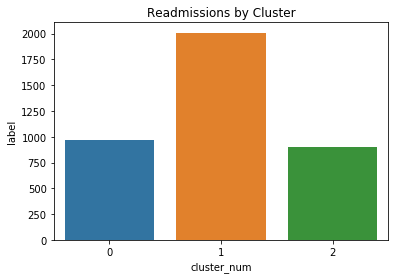

In [3]:
cluster_readmission = labeled_data.groupby(['cluster_num'])['label'].sum()
cluster_readmission = cluster_readmission.reset_index(drop=False)
total_noreadmit, total_readmit = labeled_data['label'].value_counts()
ax = sns.barplot(x='cluster_num', y='label', data=cluster_readmission).set_title('Readmissions by Cluster')
fig = ax.get_figure()
fig.savefig('results/figures/readmission_by_cluster.png')
plt.show()
plt.close()

<h3>Readmitted by Cluster (out of all patients)</h3>

Each cluster is grouped together. A percentage is then calculated: number of readmissions per cluster/all patients in the cluster. This percentage is then visualized in a bar graph.

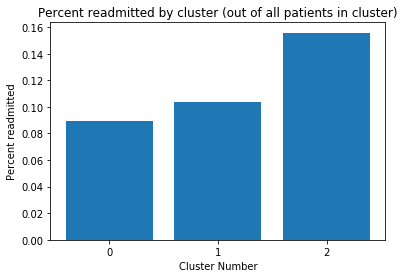

In [4]:
cluster_readmits = labeled_data['cluster_num'].value_counts()
readmits = {}
for cluster, readmit in enumerate(cluster_readmission['label']):
    readmits[cluster] = float(readmit)/float(cluster_readmits[cluster])
fig = plt.figure()
plt.bar(range(len(readmits)), list(readmits.values()), align='center')
plt.xticks(range(len(readmits)), list(readmits.keys()))
plt.ylabel('Percent readmitted')
plt.xlabel('Cluster Number')
plt.title('Percent readmitted by cluster (out of all patients in cluster)')
plt.show()
fig.savefig('results/figures/readmission_by_cluster_all_patients_in_cluster.png')
plt.close()

<h3>Percent readmitted in cluster out of all readmitted</h3>

Each cluster is grouped together and a percentage is computed: readmitted/total readmitted in cluster. This value is then visualized in a bar graph

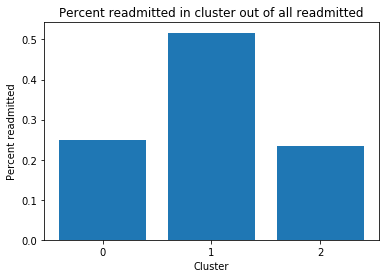

In [5]:
readmits_all = {}
readmits_r = {}
for cluster, readmit in enumerate(cluster_readmission['label']):
    readmits_all[cluster] = float(readmit)/float(total_noreadmit+total_readmit)
    readmits_r[cluster] = float(readmit)/float(total_readmit)
plt.figure()
plt.bar(range(len(readmits_r)), list(readmits_r.values()), align='center')
plt.xticks(range(len(readmits_r)), list(readmits_r.keys()))
plt.ylabel('Percent readmitted')
plt.xlabel('Cluster')
plt.title('Percent readmitted in cluster out of all readmitted')
plt.show()
fig.savefig('results/figures/readmission_by_cluster_all_readmitted.png')
plt.close()

<h2>Data Pipeline</h2>

The data is loaded in, goes through PCA, and then is fitted on several baseline classifiers.

The labeled data is loaded in and split into three clusters. The respective labels are stored in corresponding dataframes.

In [6]:
def preprocess():
    data = pd.read_csv('../data/labeled_clustered_data.csv')
    df_0 = data[(data[['cluster_num']] == 0).any(axis=1)]
    df_0_label=df_0.pop('label')
    df_1 = data[(data[['cluster_num']] == 1).any(axis=1)]
    df_1_label=df_1.pop('label')
    df_2 = data[(data[['cluster_num']] == 2).any(axis=1)]
    df_2_label=df_2.pop('label')
    dfs = [df_0, df_1, df_2]
    dfs_labels = [df_0_label, df_1_label, df_2_label]
    return dfs, dfs_labels

Parses the classification_report method from sklearn to easily store the values in a csv file

In [7]:
def classifaction_report_csv(report, filename):
    report_data = []
    lines = report.split('\n')
    for line in lines[2:-3]:
        row = {}
        row_data = line.split('      ')
        row['class'] = row_data[0]
        row['precision'] = float(row_data[1])
        row['recall'] = float(row_data[2])
        row['f1_score'] = float(row_data[3])
        row['support'] = float(row_data[4])
        report_data.append(row)
    dataframe = pd.DataFrame.from_dict(report_data)
    dataframe.to_csv(filename, index = False)

Runs PCA on a dataframe and returns the data with reduced dimensions. The n_components is decided by the index where the variance is greatest before it reaches a value of 1.

In [8]:
def run_pca(df):
    pca = PCA().fit(df)
    variances = np.cumsum(pca.explained_variance_ratio_)
    max_variance = -1
    n_components = 0
    for c in range(len(variances)):
        if variances[c] < 1 and variances[c] >  max_variance: 
            max_variance = variances[c]
            n_components = c
    reduced_data = PCA(n_components=n_components).fit_transform(df) 
    return reduced_data

Creates several baseline classifiers

In [9]:
def create_pipeline():
    pipeline = []
    lr = LogisticRegressionCV(random_state = 0, n_jobs=-1)
    en = ElasticNetCV(random_state = 0, n_jobs=-1)
    rf = RandomForestClassifier(random_state=0, n_jobs=-1)
    pipeline.append(['logistic_regression', lr]) 
    pipeline.append(['elastic_network', en]) 
    pipeline.append(['random_forest', rf])
    return pipeline

Runs PCA on each cluster, splits into training and testing sets, stores precision and recall values for each classifier

In [10]:
def pr_curve(pr_map, dimension_reduction=True):
    for cluster, clf_map in pr_map.items():
        fig=plt.figure()
        if dimension_reduction:
            plt.title('PR Curve for Cluster '+str(cluster))
            filepath = 'results/figures/'+str(cluster)+'cluster_PR.png'
        else:
            plt.title('PR Curve for Cluster '+str(cluster)+' without PCA')
            filepath = 'results/figures/'+str(cluster)+'cluster_PR_withoutPCA.png'
        for name, values in clf_map.items():
                average_precision = values[0]
                precision = values[1]
                recall = values[2]
                plt.plot(recall, precision, label=name+' (area = {:.3f})'.format(average_precision))
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.legend(loc='best')
        plt.show()
        fig.savefig(filepath)
        plt.close()

In [ ]:
def run_pipeline(dfs, dimension_reduction=True):
    dfs, dfs_labels = preprocess()
    pipeline = create_pipeline()
    pr_map = {} #maps cluster to clf to avg_precision, precision, recall
    for i, df in enumerate(dfs):
        labels = dfs_labels[i]
        if dimension_reduction:
            reduced_df = run_pca(df)
        else:
            reduced_df = df
        X_train, X_test, y_train, y_test = train_test_split(reduced_df, labels, test_size=0.2, random_state=0)
        cluster_pr = pr_map.get(i, {})
        for name, clf in pipeline:
            directory = 'results/'
            if dimension_reduction:
                filename = directory+name+'_cluster_'+str(i)+'.csv'
            else:
                filename = directory+name+'_cluster_'+str(i)+'_withoutPCA.csv'
            clf.fit(X_train, y_train)
            y_preds = [0 if x < 0.5 else 1 for x in clf.predict(X_test)]
            average_precision = average_precision_score(y_test, y_preds)
            precision, recall, _ = precision_recall_curve(y_test, y_preds)
            cluster_pr[name] = [average_precision, precision, recall]
            report = classification_report(y_test, y_preds, target_names=['Not Readmitted', 'Readmitted'])
            classifaction_report_csv(report, filename)
        pr_map[i] = cluster_pr
    pr_curve(pr_map, dimension_reduction)

In [11]:
dfs, dfs_labels = preprocess()
run_pipeline(dfs, dfs_labels, dimension_reduction=False)

Plots each precision recall curve for each cluster

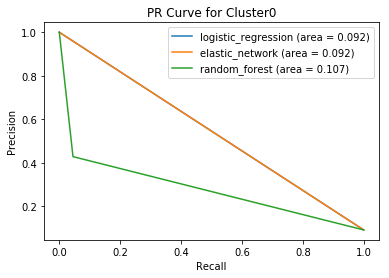

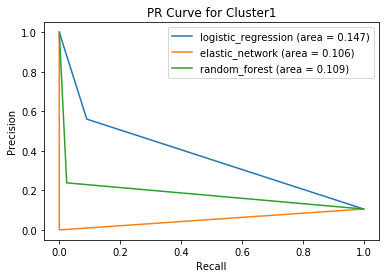

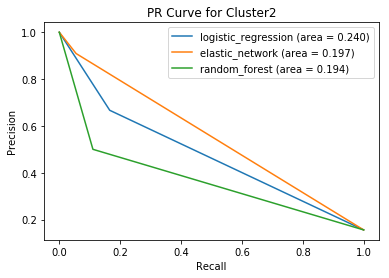